# Choose features based on their importance


In these series of experiments (14, 14_01, 14_02, 14_03) I use the non-stationarity pattern from 10_01 but use other features. Here I choose features based on their weights in a linear model learned in offline fashion. I leave the features that have high importance and several features that have low importance. In this particular experiment a have 4 features from data and one random feature. I do this to see if Algorithm1 is able to not "buy" features that are less useful for prediction.

14 - 4 features
14_01 - 5 features
14_02 - 6 features
14_03 - 4 features + 1 random feature

Non-stationarity patter replicates 10_1.
The tuning was done in notebooks 6 and 9.

Here we have features:

- parents
- has_nurs
- form	
- health	
- 1 random feature with values 1, 2 and 3 chosen at random

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
df_num['random'] = np.random.randint(1, 4, size=len(df_num))

In [14]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation,random
0,1,1,1,1,1,1,1,2,2,3
1,1,1,1,1,1,1,1,3,4,1
2,1,1,1,1,1,1,1,1,1,3
3,1,1,1,1,1,1,2,2,2,3
4,1,1,1,1,1,1,2,3,4,1
...,...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5,2
12956,3,5,4,4,3,2,2,1,1,2
12957,3,5,4,4,3,2,3,2,5,1
12958,3,5,4,4,3,2,3,3,5,2


# Dropping features
 Features are dropped according to their usefulness for the logistic regression model in experiment 13.
 
 We leave the most important features and 1 or 2 least important.

In [15]:
# final evaluation is target variable

all_contexts = df_num.drop(['social', 'finance', 'final evaluation'], axis=1)

# In this notebook also drop children column. In next we'll try how it goes together with this column.

all_contexts = all_contexts.drop(['children', 'housing'], axis=1).to_numpy()

In [16]:
all_contexts.shape

(12960, 5)

In [17]:
all_contexts

array([[1, 1, 1, 2, 3],
       [1, 1, 1, 3, 1],
       [1, 1, 1, 1, 3],
       ...,
       [3, 5, 4, 2, 1],
       [3, 5, 4, 3, 2],
       [3, 5, 4, 1, 3]])

In [18]:
y = df_num['final evaluation']

In [19]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [20]:
# Drop arms with small rewards

In [21]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [22]:
(y != 3) & (y != 2)

0        False
1         True
2         True
3        False
4         True
         ...  
12955     True
12956     True
12957     True
12958     True
12959     True
Name: final evaluation, Length: 12960, dtype: bool

In [23]:
all_contexts = all_contexts[(y != 3) & (y != 2)]

In [24]:
y = y[(y != 3) & (y != 2)]

In [25]:
y.value_counts()

1    4320
4    4266
5    4044
Name: final evaluation, dtype: int64

In [26]:
np.sum(np.where(y == 3, 1, 0))

0

In [27]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [28]:
all_rewards

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [29]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4266, 4044])

### Find which features are useful

It might be useful to move this to another notebook later for better organization.

In [30]:
from sklearn.linear_model import LinearRegression, LogisticRegression


coefs = np.zeros((all_rewards.shape[1], all_contexts.shape[1]))
for n_arm in range(all_rewards.shape[1]):
    print(n_arm)
    model = LogisticRegression()
    model.fit(all_contexts, all_rewards[:, n_arm])
    print(model.coef_)
    coefs[n_arm, :] = model.coef_


0
[[-3.62109812e-02 -2.50819544e-02 -1.38693938e-02 -1.17300454e+01
   9.20353489e-03]]
1
[[-0.97557623 -0.90015495 -0.16710202  1.45876736 -0.01866797]]
2
[[1.71600086e+00 1.55134467e+00 3.04846180e-01 3.11517598e+00
  1.70650980e-03]]


In [31]:
np.mean(coefs, axis= 0)

array([ 0.23473788,  0.20870259,  0.04129159, -2.38536735, -0.00258598])

In [32]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [33]:
all_rewards.shape[0]

12630

In [34]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, all_contexts.shape[0]),
]

In [35]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [36]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 11000, 12630]

In [37]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.34204276, 0.33776722, 0.32019002])

In [38]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [39]:
new_contexts.shape, new_rewards.shape

((12630, 5), (12630, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.0
Min expected reward for arm 3: 0.0


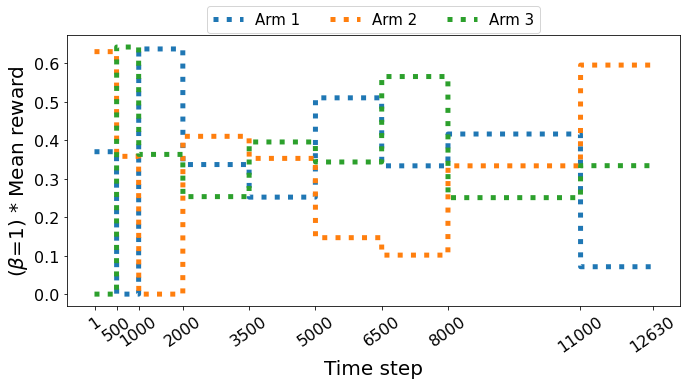

In [40]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Non-stationarity in costs

In [41]:
cost_change_points = [3000, 5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [42]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [43]:
interval_means

[array([0.01159039, 0.01976076, 0.01309632, 0.01739286, 0.01658611]),
 array([0.01847081, 0.02143273, 0.02805753, 0.01788969, 0.02962262]),
 array([0.02518056, 0.02022962, 0.02288053, 0.01204448, 0.02689043]),
 array([0.02164715, 0.02972135, 0.02272857, 0.02668223, 0.02599525]),
 array([0.01690922, 0.01519221, 0.01860987, 0.01934483, 0.01480169]),
 array([0.02789196, 0.02085096, 0.02956889, 0.02620036, 0.0211141 ])]

In [44]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [45]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

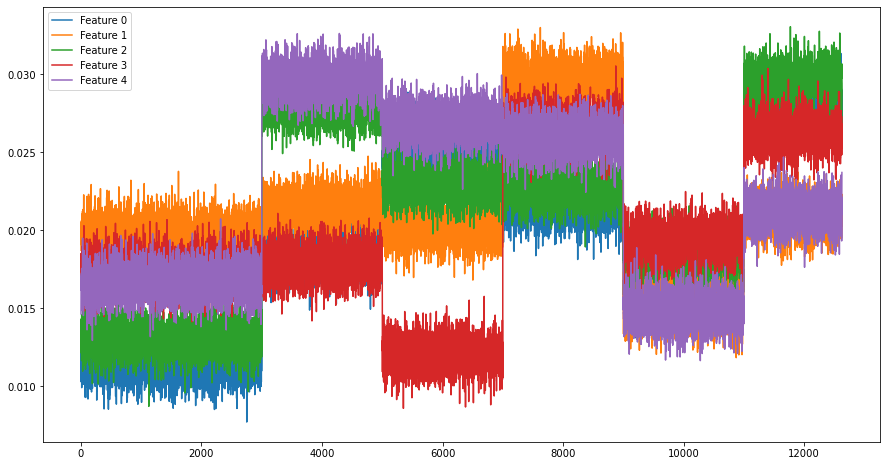

In [46]:
plot_costs(get_costs(), new_contexts.shape[0])

In [47]:
costs_obj = get_costs()

In [48]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [49]:
costs_vector.shape

(12630, 5)

## Plot expected reward minus sum of costs

In [50]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: -0.0860424179209817
Min expected gain for arm 2: -0.08536117601703991
Min expected gain for arm 3: -0.08400650067629285


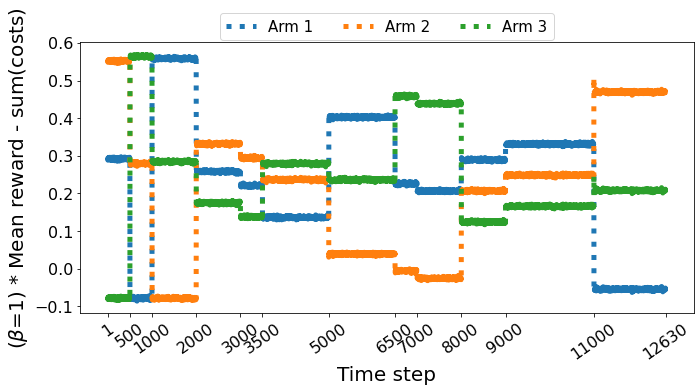

In [51]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [52]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = all_change_point_values
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

## Testing on non-stationary data

In [53]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 1

In [54]:
np.random.seed(42)

In [55]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_random
    
gain_random = np.mean(gains, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 4250.0
	Total reward: 4250.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4250.0


In [56]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.01, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4241.0
	Total reward: 4241.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4241.0


In [57]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.5,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.5)
Beta = 1
Total gain: 6073.0
	Total reward: 6073.0
	Total cost: 0
Execution time: 0.1s
Average gain: 6073.0


In [58]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.7)
Beta = 1
Total gain: 4197.413851940177
	Total reward: 5506.0
	Total cost: 1308.5861480598644
Execution time: 0.4s
Average gain: 4197.413851940177


In [59]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
        omega=100,
        delta=0.1,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 8897.413851940122
	Total reward: 10206.0
	Total cost: 1308.5861480598644
Execution time: 0.8s
Average gain: 8897.413851940122


In [60]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.03,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.002650022506713867 seconds
Trial 0, time 2022-05-10 16:46:40.466215
Trial 500, time 2022-05-10 16:46:59.864174
Trial 1000, time 2022-05-10 16:47:14.291903
Trial 1500, time 2022-05-10 16:47:31.190206
Trial 2000, time 2022-05-10 16:47:46.356352
Trial 2500, time 2022-05-10 16:48:02.093166
Trial 3000, time 2022-05-10 16:48:15.414350
Trial 3500, time 2022-05-10 16:48:32.144280
Trial 4000, time 2022-05-10 16:48:47.184379
Trial 4500, time 2022-05-10 16:49:00.433940
Trial 5000, time 2022-05-10 16:49:18.414046
Trial 5500, time 2022-05-10 16:49:31.241253
Trial 6000, time 2022-05-10 16:49:49.084194
Trial 6500, time 2022-05-10 16:50:01.905034
Trial 7000, time 2022-05-10 16:50:14.588349
Trial 7500, time 2022-05-10 16:50:32.727282
Trial 8000, time 2022-05-10 16:50:46.386497
Trial 8500, time 2022-05-10 16:50:58.908775
Trial 9000, time 2022-05-10 16:51:15.971715
Trial 9500, time 2022-05-10 16:51:29.702949
Trial 10000, time 2022-05-10 16:51:42.269410
Trial 10500, time 2022-05-10 16:51:58.754413


In [61]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.3,
        window_length=250,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1 = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_alg1

gain_alg1 = np.mean(gains, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0036721229553222656 seconds
Round 0, time 2022-05-10 16:52:57.551506
Round 500, time 2022-05-10 16:55:30.113256
Round 1000, time 2022-05-10 16:58:32.147129
Round 1500, time 2022-05-10 17:01:43.470861
Round 2000, time 2022-05-10 17:05:00.995488
Round 2500, time 2022-05-10 17:08:31.704645
Round 3000, time 2022-05-10 17:12:45.730397
Round 3500, time 2022-05-10 17:16:39.062492
Round 4000, time 2022-05-10 17:20:33.510248
Round 4500, time 2022-05-10 17:24:40.818433
Round 5000, time 2022-05-10 17:28:39.547490
Round 5500, time 2022-05-10 17:32:31.719491
Round 6000, time 2022-05-10 17:36:19.626712
Round 6500, time 2022-05-10 17:40:13.090954
Round 7000, time 2022-05-10 17:44:02.062557
Round 7500, time 2022-05-10 17:48:11.673154
Round 8000, time 2022-05-10 17:52:28.831888
Round 8500, time 2022-05-10 17:56:07.932124
Round 9000, time 2022-05-10 17:59:49.016850
Round 9500, time 2022-05-10 18:03:31.675265
Round 10000, time 2022-05-10 18:07:16.591135
Round 10500, time 2022-05-10 18:10:55.427359

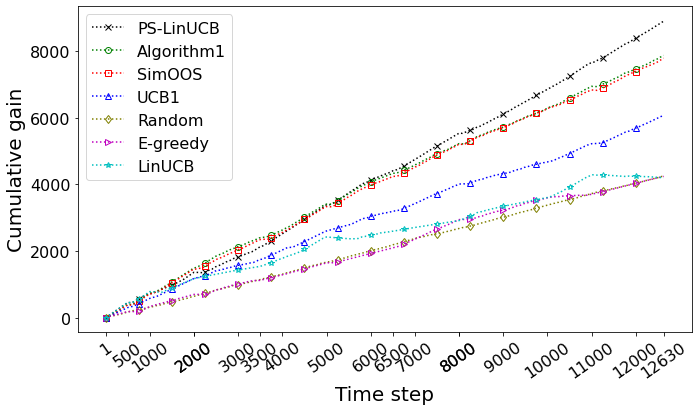

In [62]:
plot_gains({
    'Random': gain_random,
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
},
)
